<a href="https://colab.research.google.com/github/amir-jafari/SOM/blob/main/examples/Tabular/Iris/Iris_post_training_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will see how to use NNSOM with Iris dataset for post-training analysis.

In [26]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install NNSOM
    !pip install --upgrade NNSOM

In [27]:
from NNSOM.plots import SOMPlots
from NNSOM.utils import *

Load the pre-trained SOM model

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import os

model_path = "/content/drive/MyDrive/Colab Notebooks/NNSOM/Examples/Iris/"
trianed_file_name = "SOM_Model_iris_Epoch_500_Seed_1234567_Size_4.pkl"

# SOM Parameters
SOM_Row_Num = 4  # The number of row used for the SOM grid.
Dimensions = (SOM_Row_Num, SOM_Row_Num) # The dimensions of the SOM grid.

som = SOMPlots(Dimensions)
som = som.load_pickle(trianed_file_name, model_path)

Data Preparation

In [44]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Random State
from numpy.random import default_rng
SEED = 1234567
rng = default_rng(SEED)

# Data Preprocessing
X = iris.data
y = iris.target

X = X[rng.permutation(len(X))]
y = y[rng.permutation(len(X))]

scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X = np.transpose(X)

Post Processing for SOM

In [45]:
from scipy.spatial.distance import cdist

# Compute Some Statistics
x_w_dist = cdist(som.w, np.transpose(X), 'euclidean')
ind1 = np.argmin(x_w_dist, axis=0)

shapw = som.w.shape
S = shapw[0]
shapx = X.shape
Q = shapx[1]
net_ones = np.ones(S)
same_size = 100 * np.ones(S)

Clust = []
dist = []
mdist = np.zeros(S)
clustSize = []

for i in range(S):
    # Find which inputs are closest to each weight (in cluster i)
    tempclust = np.where(ind1 == i)[0]

    # Save distance of each input in the cluster to cluster center (weight)
    tempdist = x_w_dist[i, tempclust]
    indsort = np.argsort(tempdist)
    tempclust = tempclust[indsort]  # Sort indices
    tempdist = tempdist[indsort]

    # Add to distance array sorted distances
    dist.append(tempdist)

    # Add to Cluster array sorted indices
    Clust.append(tempclust)

    # Cluster size
    num = len(tempclust)
    clustSize.append(num)

    # Save the maximum distance to any input in the cluster from cluster center
    if num > 0:
        mdist[i] = tempdist[-1]

Train the classifier with Iris dataset

In [10]:
# Train Logistic Regression on Iris
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state=SEED)
logit.fit(X, y)
results = logit.predict(X)

Post Processing for the logit model

In [57]:
Ind_misclassified = [] # List of indices where the target is missclassified
for i in range(len(y)):
    if y[i] != results[i]:
        Ind_misclassified.append(i)

# Error analaysis for Sentosa
Sentosa_type1_error_index = []  # False Positives for 'SETOSA'
Sentosa_type2_error_index = []  # False Negatives for 'SETOSA'

for i in range(len(y)):
    if y[i] == 0 and results[i] != 0:
        # This is a Type 2 error for 'SETOSA' (False Negative)
        Sentosa_type2_error_index.append(i)
    elif y[i] != 0 and results[i] == 0:
        # This is a Type 1 error for 'SETOSA' (False Positive)
        Sentosa_type1_error_index.append(i)

Visualization

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

Grey Hist

In this case, the color shade indicateds the propotion of Misclassified Neuron.

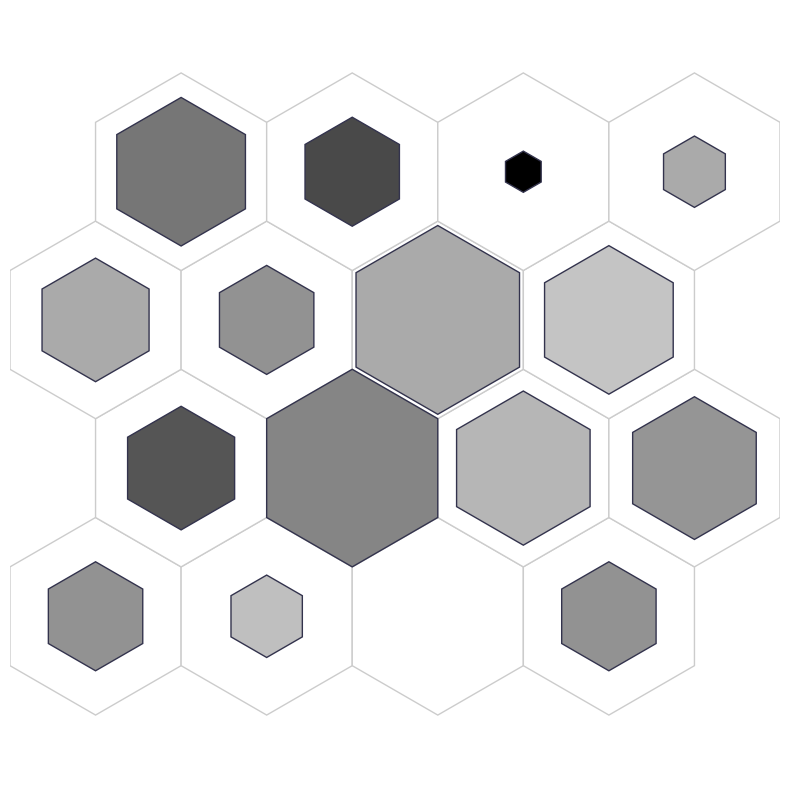

In [67]:
# Pre-processing to get the propotion of misclassified items in each neuron
proportion_misclassified = []
for i in range(S):  # S is the total number of neurons
    cluster_indices = Clust[i]
    misclassified_in_cluster = 0

    # Count how many indices in this cluster are in the list of misclassified indices
    for index in cluster_indices:
        if index in Ind_misclassified:
            misclassified_in_cluster += 1

    # Calculate the proportion of misclassified indices in this cluster
    if len(cluster_indices) > 0:
        proportion = misclassified_in_cluster / len(cluster_indices)
    else:
        proportion = 0  # Avoid division by zero if the cluster is empty

    # Add the calculated proportion to the list
    proportion_misclassified.append(proportion)

# Get percentatges for each neuron
perc_misclassified = np.array(proportion_misclassified) * 100

fig, ax, patches, text = som.gray_hist(X, perc_misclassified)
plt.show()

Color hist

The color colose to red indicates more likely to be misclassified.

/usr/local/lib/python3.10/dist-packages/NNSOM/plots.py:267: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ticktext)


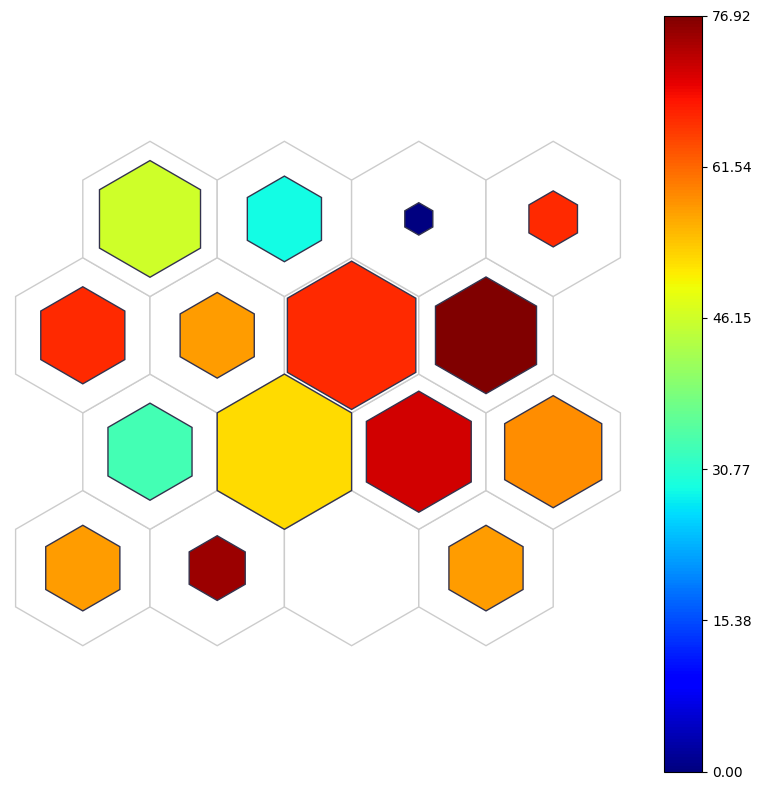

In [68]:
fig, ax, patches, text = som.color_hist(X, perc_misclassified)
plt.show()

Complex hit hist

Inner Color: Whether there are majority correctly or incorrectly classified classes. (Green misclassified dominant, blue correctly classified dominant)

Edge Color: Majority Error Type for Sentosa (Type 1 Error (red) or Type 2 Error (pink))

Edge Thickness: Number of Error

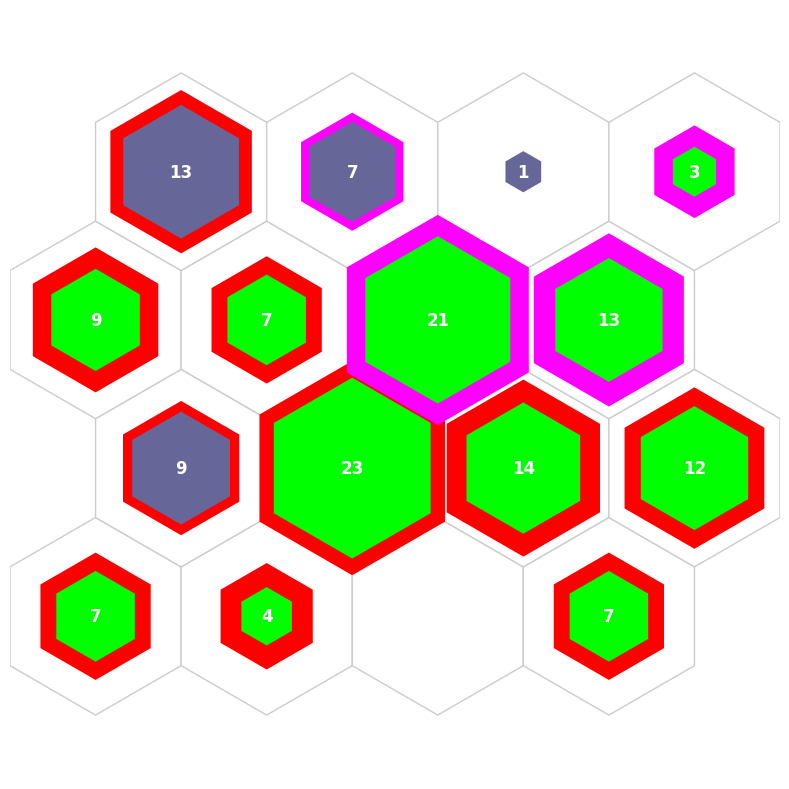

In [69]:
fig, ax, patches, text = som.cmplx_hit_hist(X, perc_misclassified, Clust, Ind_misclassified, Sentosa_type1_error_index, Sentosa_type2_error_index)
plt.show()

Simple grid

color: misclassified percentages

size: the number of sentosa

/usr/local/lib/python3.10/dist-packages/NNSOM/plots.py:547: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ticktext)


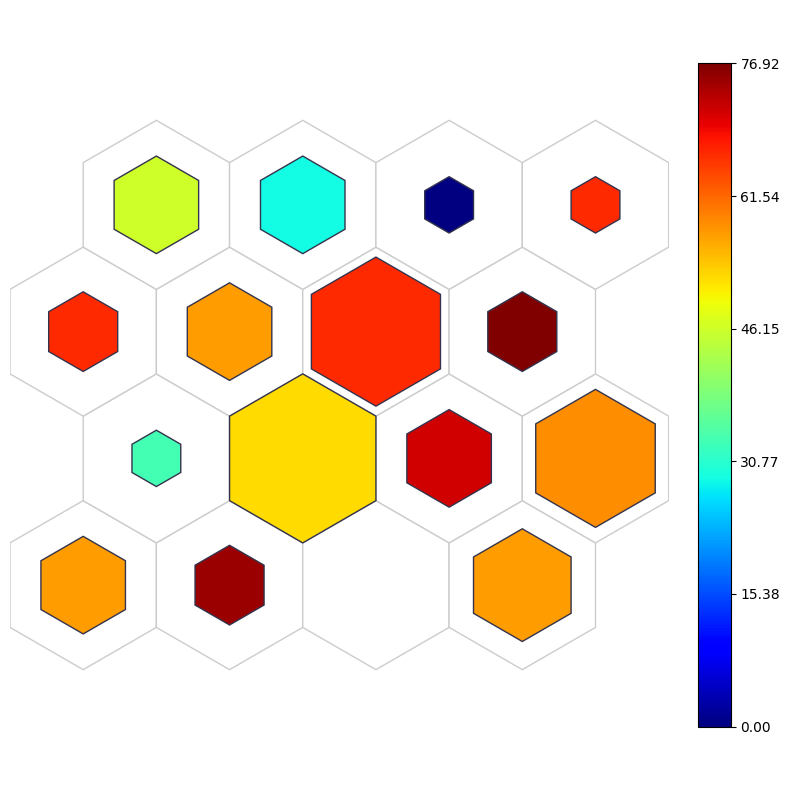

In [72]:
num_sentosa = []
for i in range(S):  # S is the number of neurons
    # Get the indices of data points in the current cluster
    cluster_indices = Clust[i]

    # Count the occurrences of 'Sentosa' in the current cluster
    sentosa_count = sum(y[index] == 0 for index in cluster_indices)

    # Append the count to the num_sentosa list
    num_sentosa.append(sentosa_count)

fig, ax, patches, cbar = som.simple_grid(perc_misclassified, num_sentosa)
plt.show()